<a href="https://colab.research.google.com/github/GPassos01/md_ml/blob/main/ProjetoML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PREVISÃO DE PREÇOS DE CRIPTOMOEDA**





Grupo: Gabriel Passos de Oliveira e Letícia Yuri Hiratsuka

O problema central deste trabalho é a previsão do preço do Bitcoin em curto prazo utilizando técnicas de aprendizado de máquina aplicadas a séries temporais.

##Coleta e análise dos dados

In [ ]:
import yfinance as yf

import pandas as pd

import matplotlib.pyplot as plt

Vamos focar na coluna 'Close' (Preço de Fechamento) como nosso alvo, entretanto usaremos outras colunas como features

In [ ]:
moeda =  'BTC-USD' #bitcoin

data = yf.download(moeda, start='2017-01-01', end='2024-12-31')

print(data.head())

data.columns = data.columns.get_level_values(0)  # deixa a linha de "titulo" com apenas 1 nivel de nome
data.reset_index(inplace=True) # transforma a coluna "Date" q tava como coluna indice em uma coluna padrao. inplace=True aplica o novo indice no dataframe atual

print("Dados coletados:")
print(data.head())
data.shape

/tmp/ipython-input-2825583970.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(moeda, start='2017-01-01', end='2024-12-31')
[*********************100%***********************]  1 of 1 completed

Price             Close         High          Low         Open     Volume
Ticker          BTC-USD      BTC-USD      BTC-USD      BTC-USD    BTC-USD
Date                                                                     
2017-01-01   998.325012  1003.080017   958.698975   963.658020  147775008
2017-01-02  1021.750000  1031.390015   996.702026   998.617004  222184992
2017-01-03  1043.839966  1044.079956  1021.599976  1021.599976  185168000
2017-01-04  1154.729980  1159.420044  1044.400024  1044.400024  344945984
2017-01-05  1013.380005  1191.099976   910.416992  1156.729980  510199008
Dados coletados:
Price       Date        Close         High          Low         Open  \
0     2017-01-01   998.325012  1003.080017   958.698975   963.658020   
1     2017-01-02  1021.750000  1031.390015   996.702026   998.617004   
2     2017-01-03  1043.839966  1044.079956  1021.599976  1021.599976   
3     2017-01-04  1154.729980  1159.420044  1044.400024  1044.400024   
4     2017-01-05  1013.380005  

(2921, 6)

In [ ]:
print(data.info())

print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2921 entries, 0 to 2920
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2921 non-null   datetime64[ns]
 1   Close   2921 non-null   float64       
 2   High    2921 non-null   float64       
 3   Low     2921 non-null   float64       
 4   Open    2921 non-null   float64       
 5   Volume  2921 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 137.1 KB
None
Price                 Date          Close           High            Low  \
count                 2921    2921.000000    2921.000000    2921.000000   
mean   2020-12-31 00:00:00   25054.346674   25588.625953   24435.845465   
min    2017-01-01 00:00:00     777.757019     823.307007     755.755981   
25%    2019-01-01 00:00:00    7397.796875    7535.716797    7233.399414   
50%    2020-12-31 00:00:00   17130.486328   17567.699219   16812.369141   
75%    2022-12-3

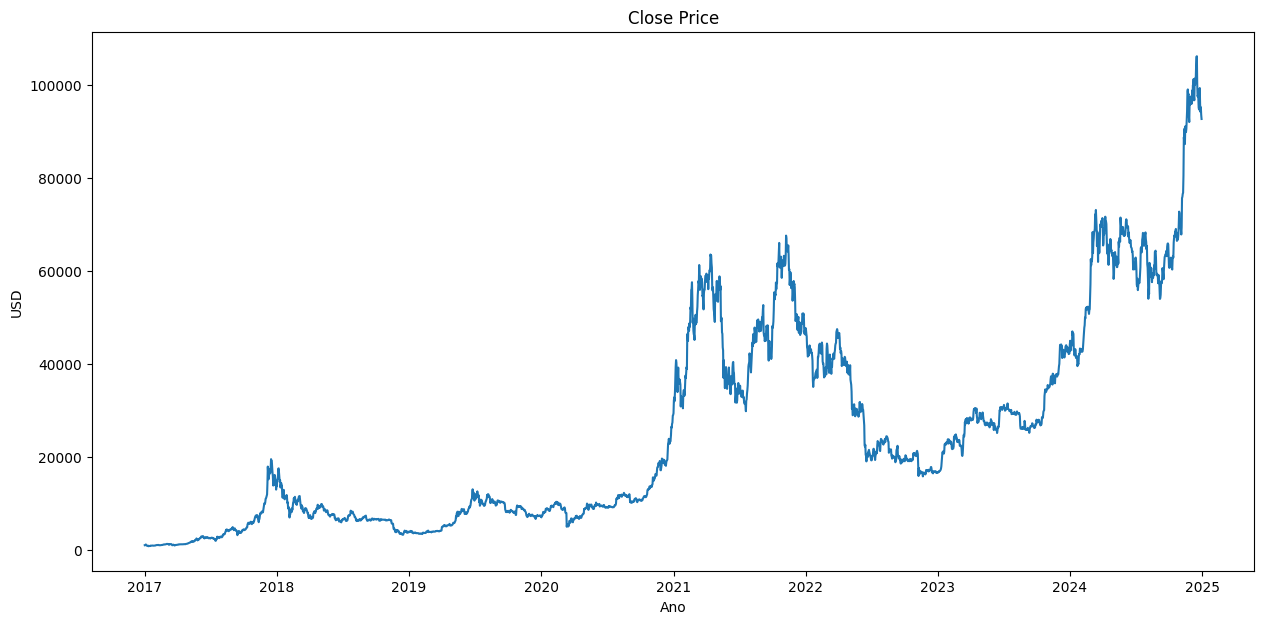

In [ ]:
plt.figure(figsize=(15, 7))
plt.title('Close Price')
plt.plot(data['Date'], data['Close'])
plt.xlabel('Ano')
plt.ylabel('USD')
plt.show()


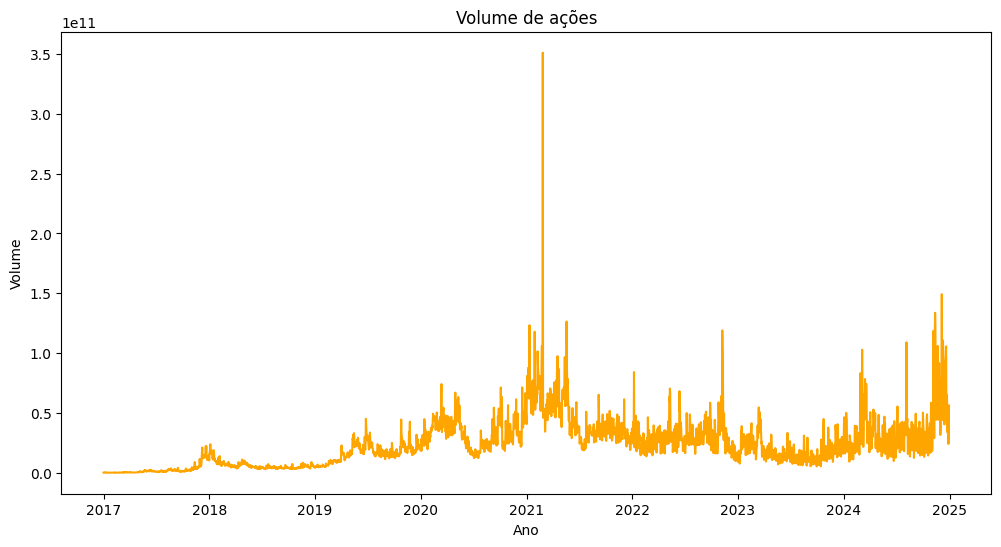

In [ ]:
plt.figure(figsize=(12,6))
plt.title('Volume de ações')
plt.plot(data['Date'], data['Volume'], color='orange')
plt.xlabel('Ano')
plt.ylabel('Volume')
plt.show()

In [ ]:
import seaborn as sns

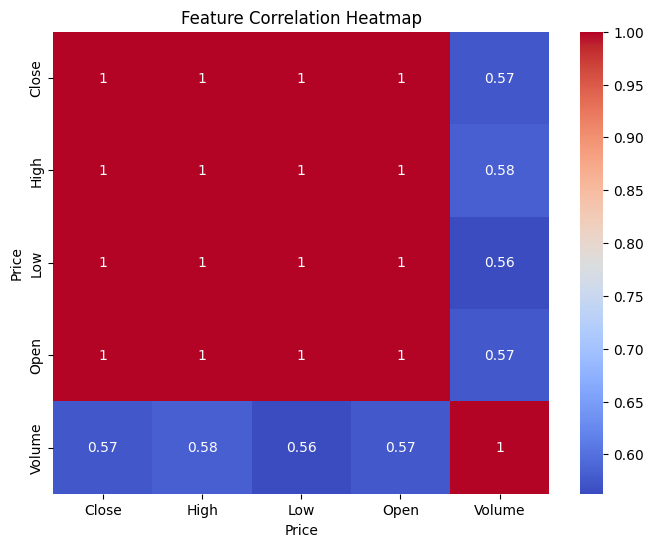

In [ ]:
dados_numericos = data.select_dtypes(include=["int64","float64"])
plt.figure(figsize=(8,6))
sns.heatmap(dados_numericos.corr(), annot=True, cmap="coolwarm")
plt.title('Feature Correlation Heatmap')
plt.show()

##Pré-processamento


Geração de variáveis derivadas (Indicadores Técnicos)

In [ ]:
featured_data = data.copy()


# Média Móvel Simples
featured_data["SMA_20"] = featured_data['Close'].rolling(window=20).mean()
# Variação Percentual Diária
featured_data["Pct_Change"] = featured_data['Close'].pct_change()
# Média Móvel Exponencial - EMA
featured_data["EMA_10"] = featured_data['Close'].ewm(span=10, adjust=False).mean()

# Remoção de valores NaN gerados pelas janelas (rolling/pct_change)
featured_data = featured_data.dropna()



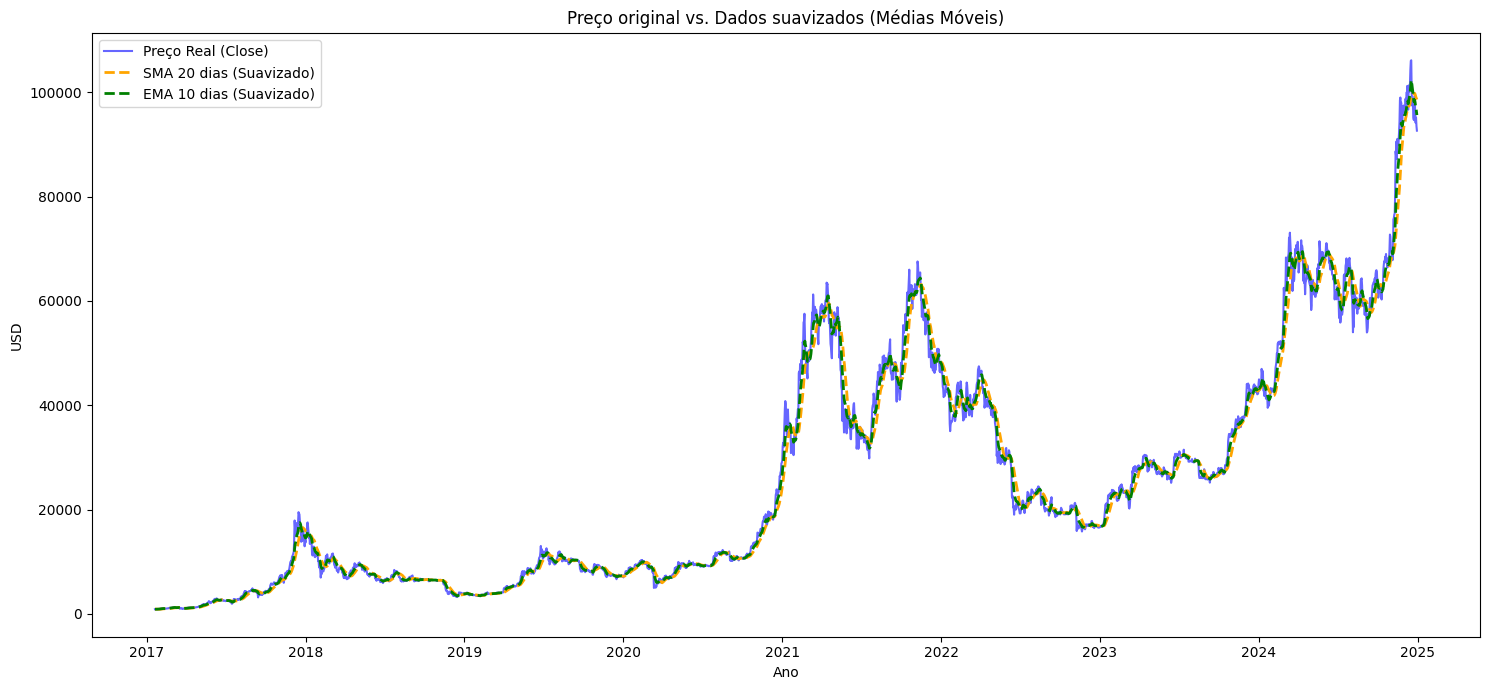

In [ ]:
"""Plota o preço de fechamento original contra as médias móveis (SMA e EMA)
para comparação visual."""

plt.figure(figsize=(15, 7))
plt.plot(featured_data['Date'], featured_data['Close'], label="Preço Real (Close)", color="blue", alpha=0.6, linewidth=1.5)
plt.plot(featured_data['Date'], featured_data['SMA_20'], label="SMA 20 dias (Suavizado)", color="orange", linestyle="--", linewidth=2)
plt.plot(featured_data['Date'], featured_data['EMA_10'], label="EMA 10 dias (Suavizado)", color="green", linestyle="--", linewidth=2)

plt.title("Preço original vs. Dados suavizados (Médias Móveis)")
plt.xlabel("Ano")
plt.ylabel("USD")

plt.legend()
plt.tight_layout()
plt.show()


Separação dos dados em 80% treino e 20% teste

In [ ]:
split_idx = int(len(featured_data) * 0.8)
train_data = featured_data.iloc[:split_idx]
test_data = featured_data.iloc[split_idx:]

Normalização dos atributos numéricos com MinMax

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
feature_columns = train_data.columns.drop(['Date'])
print(feature_columns)

scaler_features = MinMaxScaler()
scaled_train_data = train_data.copy()
scaled_train_data[feature_columns] = scaler_features.fit_transform(train_data[feature_columns])
#    fit_transform() calcula valores maximos e minimos pra cada feature no train_data[feature_columns] e depois escala os dados pra valores entre 0 e 1.
#    O dado escalado substitui a feature original.

scaler_target = MinMaxScaler()
scaler_target.fit(train_data[['Close']])

scaled_test_data = test_data.copy()
scaled_test_data[feature_columns] = scaler_features.transform(test_data[feature_columns])

Index(['Close', 'High', 'Low', 'Open', 'Volume', 'SMA_20', 'Pct_Change',
       'EMA_10'],
      dtype='object', name='Price')


In [ ]:
# Amostra dos dados de treino normalizados
scaled_train_data[feature_columns].head()

Price,Close,High,Low,Open,Volume,SMA_20,Pct_Change,EMA_10
19,0.000035,0.000000,0.000000,0.000094,0.000074,0.000538,0.588295,0.000000
20,0.000436,0.000412,0.000130,0.000054,0.000143,0.000477,0.643413,0.000121
21,0.000480,0.000562,0.000161,0.000454,0.000159,0.000399,0.600519,0.000229
22,0.000425,0.000425,0.000454,0.000504,0.000036,0.000300,0.589163,0.000306
23,0.000000,0.000365,0.000081,0.000281,0.000144,0.000090,0.546234,0.000288


Criação das janelas temporais (Para LSTM)

In [ ]:
import numpy as np

In [ ]:
def create_dataset(dataset, target_col, timesteps):
    X, y = [], []
    target_idx = dataset.columns.get_loc(target_col)

    for i in range(timesteps, len(dataset)):
        X.append(dataset.iloc[i - timesteps : i].values)
        y.append(dataset.iloc[i, target_idx])

    return np.array(X), np.array(y)

In [ ]:
timesteps = 60


X_train, y_train = create_dataset(scaled_train_data[feature_columns], 'Close', timesteps)
X_test, y_test = create_dataset(scaled_test_data[feature_columns], 'Close', timesteps)

print(f"\nShape de X_train: {X_train.shape} \nShape de X_test: {X_test.shape}")

y_test_real = scaler_target.inverse_transform(y_test.reshape(-1, 1)).flatten()



Shape de X_train: (2261, 60, 8) 
Shape de X_test: (521, 60, 8)


------ Pensar em realizar validação cruzada para encontrar o melhor modelo ------
(hiperparametros, janela temporal etc)

Validação temporal e buca de hiperparâmetros

In [ ]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
from math import sqrt
import time

# Separar parte final do conjunto de treino para validação temporal
val_size = int(len(X_train) * 0.2)
X_train_sub, X_val = X_train[:-val_size], X_train[-val_size:]
y_train_sub, y_val = y_train[:-val_size], y_train[-val_size:]

print(f"Tamanho treino: {len(X_train_sub)}, validação: {len(X_val)}, teste: {len(X_test)}")

# Função para construir o modelo de forma parametrizável
def build_lstm(units=50, dropout_rate=0.2, input_shape=(60, X_train.shape[2])):
    model = Sequential()
    model.add(LSTM(50, activation="relu", input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))

    model.compile(optimizer="adam", loss="mean_squared_error")
    return model

# Grade simples de hiperparâmetros
param_grid = {
    "units": [50, 100],
    "batch_size": [1,16,32],
    "epochs": [20,40]
}

best_rmse = np.inf
best_params = None
best_model = None

# Busca manual
for units in param_grid["units"]:
    for batch in param_grid["batch_size"]:
        for ep in param_grid["epochs"]:
            print(f"\nTreinando modelo: units={units}, batch={batch}, epochs={ep}")
            model = build_lstm(units=units)

            start = time.time()
            history = model.fit(
                X_train_sub, y_train_sub,
                validation_data=(X_val, y_val),
                epochs=ep,
                batch_size=batch,
                verbose=0,
                shuffle=False
            )
            elapsed = time.time() - start

            # Avaliação na validação
            y_pred_val = model.predict(X_val)
            rmse_val = sqrt(mean_squared_error(y_val, y_pred_val))
            print(f"RMSE validação: {rmse_val:.5f} (tempo: {elapsed:.1f}s)")

            # Atualiza melhor modelo
            if rmse_val < best_rmse:
                best_rmse = rmse_val
                best_params = (units, batch, ep)
                best_model = model

print("\nMelhor configuração encontrada:")
print(f"Units={best_params[0]}, Batch={best_params[1]}, Epochs={best_params[2]}")
print(f"RMSE validação = {best_rmse:.5f}")


Tamanho treino: 1809, validação: 452, teste: 521

Treinando modelo: units=50, batch=1, epochs=20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
RMSE validação: 0.08265 (tempo: 499.5s)

Treinando modelo: units=50, batch=1, epochs=40


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
RMSE validação: 0.02980 (tempo: 1021.2s)

Treinando modelo: units=50, batch=16, epochs=20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
RMSE validação: 0.04455 (tempo: 58.0s)

Treinando modelo: units=50, batch=16, epochs=40


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
RMSE validação: 0.03223 (tempo: 116.2s)

Treinando modelo: units=50, batch=32, epochs=20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
RMSE validação: 0.02364 (tempo: 36.7s)

Treinando modelo: units=50, batch=32, epochs=40


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
RMSE validação: 0.05927 (tempo: 73.7s)

Treinando modelo: units=100, batch=1, epochs=20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
RMSE validação: 0.12967 (tempo: 562.4s)

Treinando modelo: units=100, batch=1, epochs=40


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
RMSE validação: 0.06979 (tempo: 1175.5s)

Treinando modelo: units=100, batch=16, epochs=20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
RMSE validação: 0.03714 (tempo: 59.4s)

Treinando modelo: units=100, batch=16, epochs=40


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
RMSE validação: 0.02688 (tempo: 110.9s)

Treinando modelo: units=100, batch=32, epochs=20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
RMSE validação: 0.02608 (tempo: 34.3s)

Treinando modelo: units=100, batch=32, epochs=40


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
RMSE validação: 0.08583 (tempo: 77.9s)

Melhor configuração encontrada:
Units=50, Batch=32, Epochs=20
RMSE validação = 0.02364


##Treinamento dos modelos

In [ ]:
#from typing import Dict, List, Tuple

from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split

In [ ]:
def train_linear_regression(X_train, y_train, X_test, scaler_close):

# Achata (reshape) de 3D para 2D:
  n_samples, timesteps, n_features = X_train.shape
  X_train_lr = X_train.reshape((n_samples, timesteps * n_features))
  X_test_lr = X_test.reshape((X_test.shape[0], timesteps * n_features))

  model = LinearRegression()
  model.fit(X_train_lr, y_train)

  preds_scaled = model.predict(X_test_lr).reshape(-1, 1)
  preds = scaler_close.inverse_transform(preds_scaled)
  return preds.flatten()


In [ ]:
"""def train_lstm(X_train, y_train, X_test, y_test, scaler_close, best_params):
    model = Sequential()
    model.add(LSTM(50, activation="relu", input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))

    #model.summary()

    model.compile(optimizer="adam", loss="mean_squared_error")
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

    preds_scaled = model.predict(X_test)
    preds = scaler_close.inverse_transform(preds_scaled)
    return preds.flatten()
"""

'def train_lstm(X_train, y_train, X_test, y_test, scaler_close, best_params):\n    model = Sequential()\n    model.add(LSTM(50, activation="relu", input_shape=(X_train.shape[1], X_train.shape[2])))\n    model.add(Dense(1))\n\n    #model.summary()\n\n    model.compile(optimizer="adam", loss="mean_squared_error")\n    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))\n\n    preds_scaled = model.predict(X_test)\n    preds = scaler_close.inverse_transform(preds_scaled)\n    return preds.flatten()\n'

In [ ]:
def train_lstm(X_train, y_train, X_test, y_test, scaler_close, best_params):
  print("\nTreinando o modelo final otimizado no conjunto de treino completo...")
  final_model = build_lstm(units=best_params[0], input_shape=(X_train.shape[1], X_train.shape[2]))

  final_model.fit(
      X_train, y_train,
      epochs=best_params[2],
      batch_size=best_params[1],
      verbose=1,
      shuffle=False
  )

  # Previsões no conjunto de teste com o modelo OTIMIZADO
  y_pred_lstm_optimized = final_model.predict(X_test)

  # Reescalar para valores reais
  y_pred_real_optimized = scaler_target.inverse_transform(y_pred_lstm_optimized)

  # Salvar no dicionário para comparação
  predictions["LSTM Otimizado"] = y_pred_real_optimized.flatten()

  print("Previsões do LSTM Otimizado salvas.")

In [ ]:
def train_arima(train_series, test_series, order=(5, 1, 0)):
  history = list(train_series.astype(float))
  forecasts = []

  for real_value in test_series.astype(float):
      model = ARIMA(history, order=order)
      fitted_model = model.fit()
      forecast = fitted_model.forecast(steps=1)[0]
      forecasts.append(float(forecast))
      history.append(float(real_value))

  return np.asarray(forecasts)


In [ ]:
predictions = {}

print("\nTreinando Regressão Linear\n")
predictions["Linear Regression"] = train_linear_regression(X_train, y_train, X_test, scaler_target)

print("\nTreinando LSTM\n")

#predictions["LSTM"] = train_lstm(X_train, y_train, X_test, y_test, scaler_target, best_params)
train_lstm(X_train, y_train, X_test, y_test, scaler_target, best_params)


Treinando Regressão Linear


Treinando LSTM


Treinando o modelo final otimizado no conjunto de treino completo...
Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0039
Epoch 2/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0060
Epoch 3/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0029
Epoch 4/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.0018
Epoch 5/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0013
Epoch 6/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0011
Epoch 7/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 7.6195e-04
Epoch 8/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 6.1397e-04
Epoch 9/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 5.3602e-04
Epoch 10/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 4.9388e-04
Epoch 11/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 4.7495e-04
Epoch 12/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 4.7522e-04
Epoch 13/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 4.8344e-04
Epoch 14/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 4.9467e-04
Epoch 15/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/ste

In [ ]:
# A série de treino para o ARIMA inclui o histórico necessário para as primeiras janelas do teste
arima_train_idx = len(train_data)
train_series_arima = featured_data['Close'].iloc[:arima_train_idx]
test_series_arima = featured_data['Close'].iloc[arima_train_idx:]
print("\nTreinando ARIMA\n")
predictions["ARIMA"] = train_arima(train_series_arima, test_series_arima)



Treinando ARIMA



##Avaliação




In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [ ]:
def avaliar_modelos(y_true, predictions, y_test_arima):
    results = {}
    for model_name, preds in predictions.items():
        if model_name == "ARIMA":
            mae = mean_absolute_error(y_test_arima, preds)
            rmse = np.sqrt(mean_squared_error(y_test_arima, preds))
            mape = mean_absolute_percentage_error(y_test_arima, preds)
        else:
            mae = mean_absolute_error(y_true, preds)
            rmse = np.sqrt(mean_squared_error(y_true, preds))
            mape = mean_absolute_percentage_error(y_true, preds)

        results[model_name] = {"MAE": mae, "RMSE": rmse, "MAPE": mape}

    return results

In [ ]:
# O y_test para o ARIMA é a série original, que deve alinhar com y_test_real
y_test_arima = test_data['Close'].values

results = avaliar_modelos(y_test_real, predictions, y_test_arima)

In [ ]:
for model_name, metrics in results.items():
  print(f"\nResultados para {model_name}:")
  print(f"  MAE: {metrics['MAE']:.4f}")
  print(f"  RMSE: {metrics['RMSE']:.4f}")
  print(f"  MAPE: {metrics['MAPE']:.4f}")


Resultados para Linear Regression:
  MAE: 1350.2780
  RMSE: 1885.8449
  MAPE: 0.0233

Resultados para LSTM Otimizado:
  MAE: 7241.8227
  RMSE: 8008.3110
  MAPE: 0.1315

Resultados para ARIMA:
  MAE: 1001.5431
  RMSE: 1535.2088
  MAPE: 0.0177


#Visualização

In [ ]:
from matplotlib.dates import DateFormatter, YearLocator

In [ ]:
def plot_predictions(dates, y_real, predictions):
  colors = {"Linear Regression": "orange","LSTM": "green","ARIMA": "red"}

  plt.figure(figsize=(15, 7))
  plt.plot(dates, y_real, label="Preço Real (BTC)", color="blue", linewidth=2)

  for model_name, preds in predictions.items():
      plot_dates = dates
      # Alinha as datas com as previsões, já que modelos baseados em janelas
      # (LSTM/LR) produzem menos previsões que o tamanho do conjunto de teste.
      if len(preds) < len(dates):
          plot_dates = dates.iloc[len(dates) - len(preds) :]
      plt.plot(
          plot_dates,
          preds,
          label=f"Previsto ({model_name})",
          linestyle="--",
          color=colors.get(model_name),
      )

  plt.title("Comparação de Previsão de Preços do Bitcoin")
  plt.xlabel("Data")
  plt.ylabel("Preço (USD)")
  axis = plt.gca()
  axis.xaxis.set_major_locator(YearLocator())
  axis.xaxis.set_major_formatter(DateFormatter("%Y"))

  plt.legend()
  plt.tight_layout()
  plt.show()

In [ ]:
def plot_rmse(results):
  model_names = list(results.keys())
  rmse_values = [results[name]["RMSE"] for name in model_names]
  colors = ["orange", "green", "red"]

  plt.figure(figsize=(10, 5))
  plt.bar(model_names, rmse_values, color=colors[: len(model_names)])
  plt.title("Comparação de Erro (RMSE) entre Modelos")
  plt.xlabel("Modelo")
  plt.ylabel("Root Mean Squared Error (RMSE)")
  plt.tight_layout()
  plt.show()

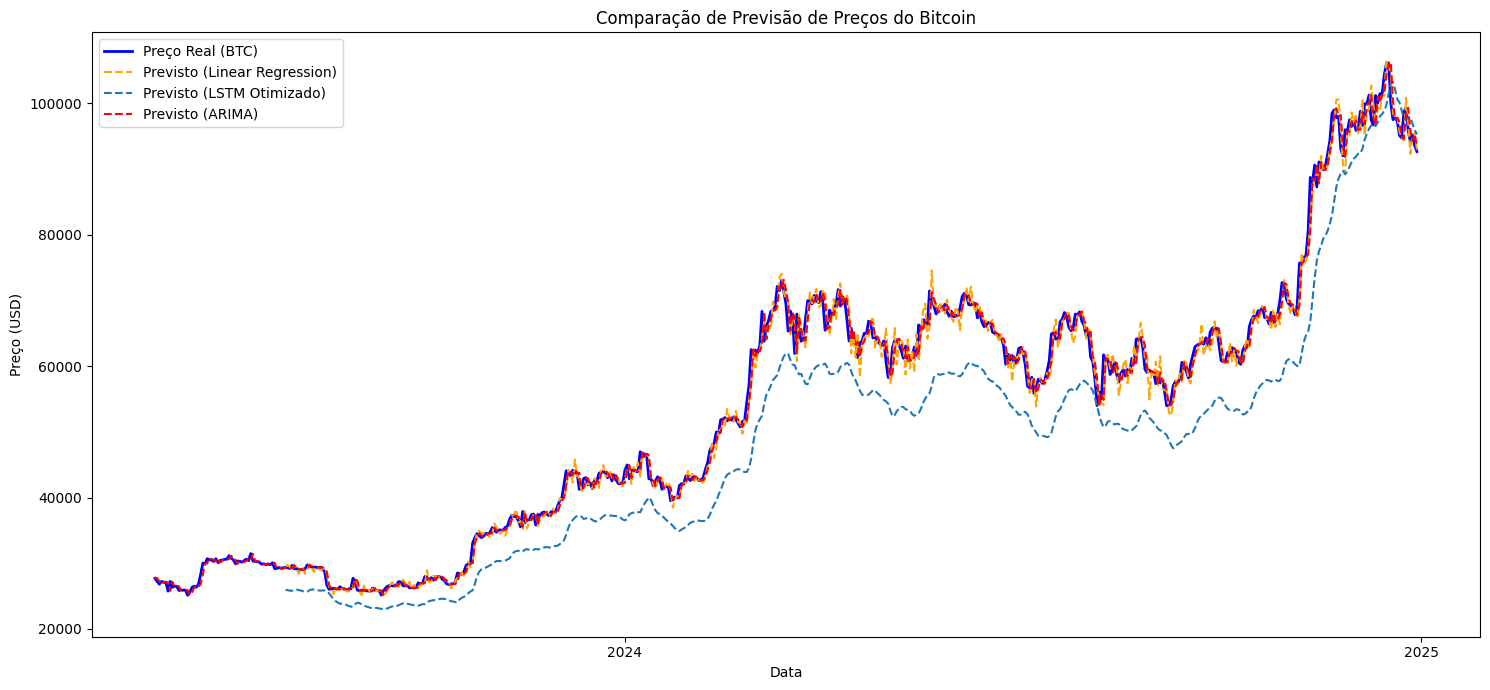

In [ ]:
test_dates = test_data["Date"]
plot_predictions(test_dates, test_series_arima.values, predictions)


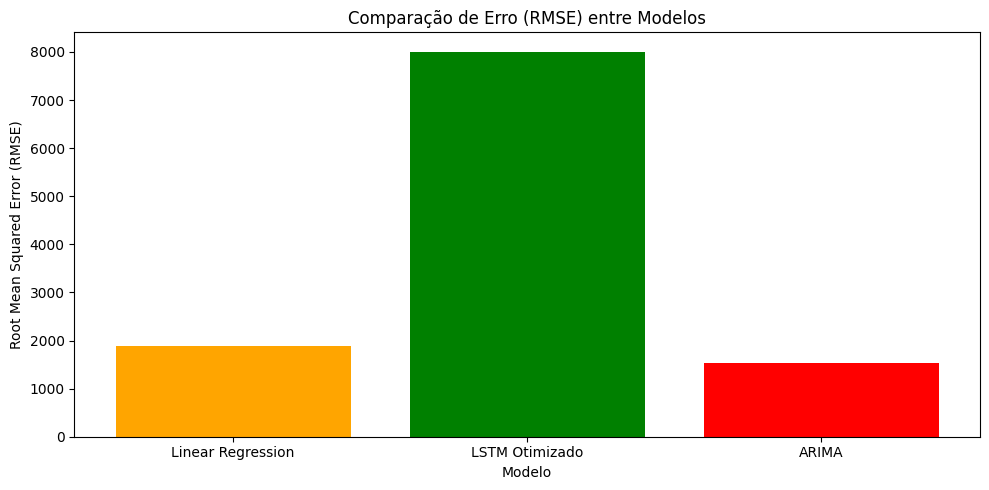

In [ ]:
plot_rmse(results)